In [1]:
#imports 

%tensorflow_version 2.x
import tensorflow as tf 
from tensorflow import keras 

#Help-liberies 
import numpy as np
import matplotlib.pyplot as plt
from random import randrange, uniform

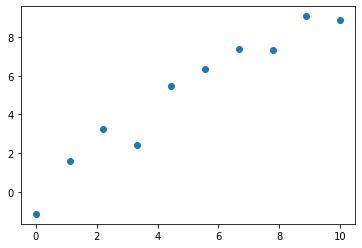

In [ ]:
#creating a set of n random points, which are distributed around a lineare function mx+c 
#the intervall where the points are distributed is [a,b]
#a good choice for sigma might be n/10

def create_random_points(n,a,b,m,c,sig):
  x_values = np.linspace(a,b,n)
  x_values.sort()
  #let the y-values be normaly distributed around the linear function mx + c
  y_values = np.array([np.random.normal(m*x +c,sig,1)[0] for x in x_values])
  c =  [list(c) for c in zip(x_values, y_values)]
  return np.array(c)

#here we can see a test plot
data = create_random_points(10,0,10,1,0,1)
x = data[:,0]
y = data[:,1]
plt.scatter(x,y)  




In [ ]:
#Now we want to create a model with n rff features, where we can learn the function with the datapoints
def create_rff_model(features):
  model = keras.Sequential([
    keras.Input(shape=(1,)),
    keras.layers.experimental.RandomFourierFeatures(
        output_dim=features,
        kernel_initializer='gaussian'),
    keras.layers.Dense(units=1, activation='linear'),
  ])
  model.compile(
      optimizer=keras.optimizers.SGD(lr=0.13),
      loss=keras.losses.MeanSquaredError(),
      metrics=['categorical_accuracy']
  )
  return model



'''
This method trains n models and then lets the 
models predict the function, which is calculated of the given data
(10 random points). The models are trained until the loss is under a certain bound 
or a certain amount of epochs is reached. 
The return value is a array of function which the models predict 
''' 
def train_models(models, data, labels):
  predictions = []
  for m in models:
    loss = 100
    epoch_counter =  0
    #training the model until a certain loss is reached or 10000 epochs are reached
    while(loss > 0.001 and epoch_counter < 50000):
      history = m.fit(data,labels,10)
      epoch_counter = epoch_counter + 10
      train_loss, train_acc = history.history.values()
      loss = train_loss[len(train_loss) -1]
      if loss < 0.000001 and epoch_counter > 5000:
        break

    pred_x= np.linspace(min(data),max(data),100)
    pred_y= [m.predict(p)[0] for p in [[x] for x in pred_x]]
    predictions.append([np.array(pred_x),np.array(pred_y)])

  return predictions




In [ ]:
#plotting the results 
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm

def plot_regression(predictions,modelsizes,data, labels):
  viridis = cm.get_cmap('viridis', 12)
  colors = [viridis(x) for x in np.linspace(0.4,0.99,len(predictions))]

  fig, ax = plt.subplots(1)
  fig.set_size_inches(20,20)
  for i in range(len(predictions)):
    ax.plot(predictions[i],linewidth=3.0, color = colors[i], label = str(modelsizes[i]) + " RFFs" ) 
    
  ax.scatter(data,labels,color = "black",s=200, label = "data-points")


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 9ms/step - loss: 8.4047e-04 - categorical_accuracy: 1.0000


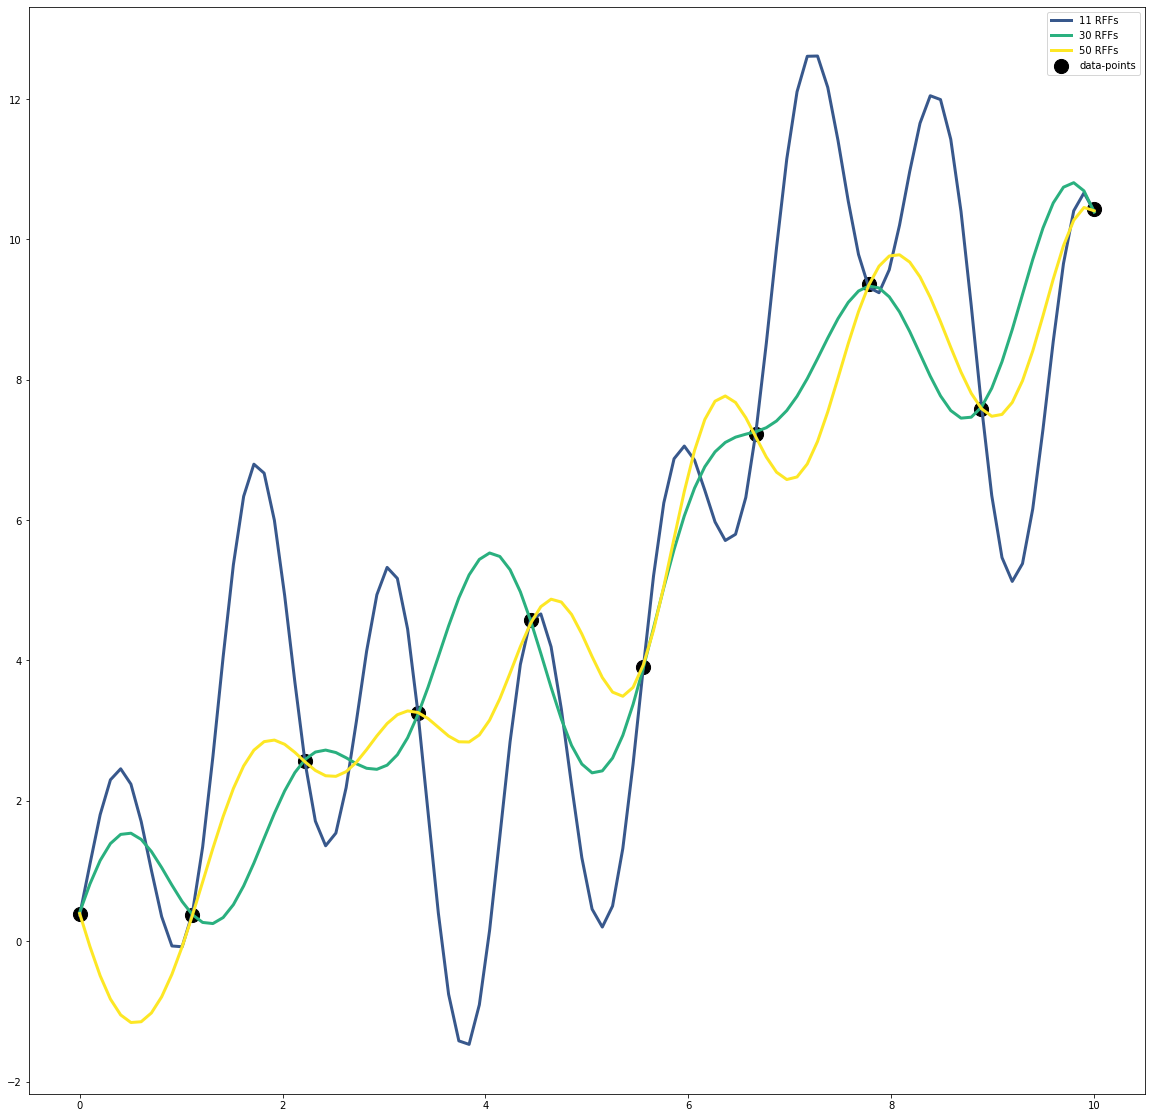

In [ ]:
def plot_regression(predictions,modelsizes,data, labels):
  viridis = cm.get_cmap('viridis', 12)
  colors = [viridis(x) for x in np.linspace(0.3,0.99,len(predictions))]

  fig, ax = plt.subplots(1)
  fig.set_size_inches(20,20)
  
  for i in range(len(predictions)):
    ax.plot(predictions[i][0],predictions[i][1][:,0],color = colors[i],linewidth=3.0, label = str(modelsizes[i]) + " RFFs" ) 

  ax.scatter(data,labels,color = "black",s=200, label = "data-points")
  ax.legend()

modelsize = [11,30, 50]
models = [ create_rff_model(i) for i in modelsize]
predictions = train_models(models,x,y) 
plot_regression(predictions, modelsize,x,y)

Now we want to solve a Regression problem in 3d. Lets take a look how that will show up


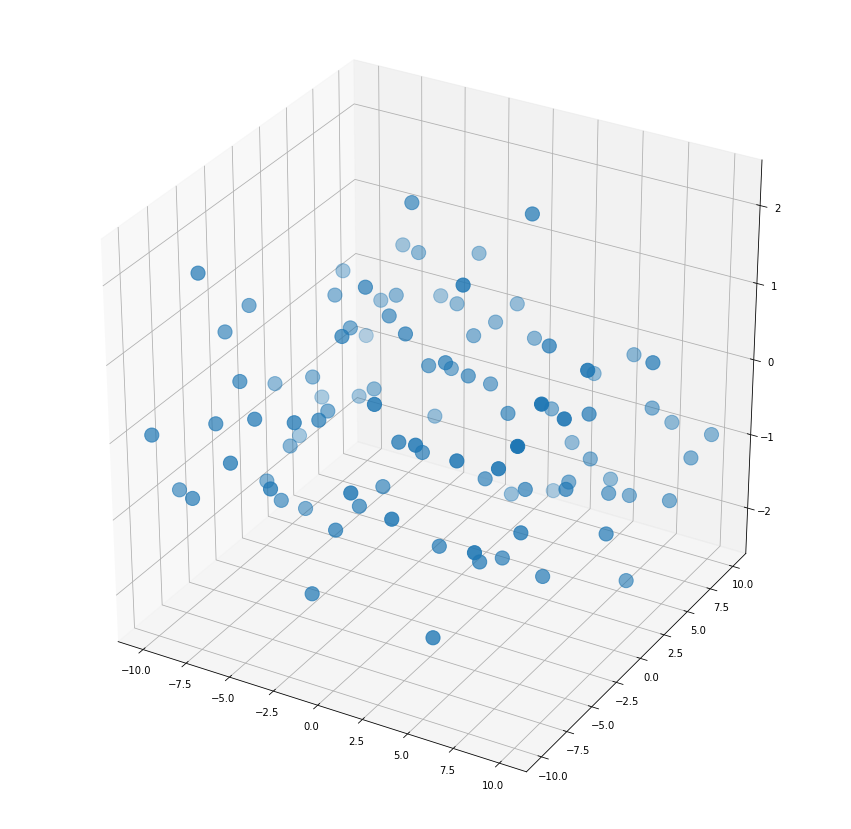

In [2]:
#now we want to take a look at this kind of an example in the 3d Space
#lets again create some random points

'''
creating n points in a sqare of [-a,a]x[-b,b] 
the function f goes from R^2 -> R ((x,y) ->  z = c - (|x| + |y|)) 
where z is a value which is normaly distributed with N(z,sig)
around c 
'''

def create_random_points_3d(n,a,b,c,sig):
  x = np.linspace(-a, a, int(np.sqrt(n)))
  y = np.linspace(-b, b, int(np.sqrt(n)))
  xx, yy = np.meshgrid(x,y)
  #let the z values be normaly distributed around z
  z = [[np.random.normal(c,sig,1) for a in x] for b in y]
  return [xx,yy,z] 


#here we can see a test plot
data_x,data_y,label_z = create_random_points_3d(100,10,10,0,1)


fig = plt.figure()
fig.set_size_inches(15,15)
ax = fig.add_subplot(projection='3d')
ax.scatter(data_x,data_y,label_z,s=200,label = "data-points")


In [3]:
'''
creating a model which should approximate the discribed function above
We once again use Random-fourier-Features. The inputshape is (2,1)
and the outputshape is (1, )
'''

def create_rff_model_3d(features):
  model = keras.Sequential([
    keras.layers.Flatten(input_shape=(2,)),
    keras.layers.experimental.RandomFourierFeatures(
        output_dim=features,
        kernel_initializer='gaussian'),
    keras.layers.Dense(units=1, activation='linear'),
  ])
  model.compile(
      optimizer=keras.optimizers.SGD(lr=1/features),
      loss=keras.losses.MeanSquaredError(),
      metrics=['categorical_accuracy']
  )
  return model


def train_models_3d(models,data_x,data_y,labels):
  predictions = []
  data = np.array([list(a) for a in zip(np.concatenate(data_x),np.concatenate(data_y))])
  labels = np.array(np.concatenate(labels))

  for m in models:
    loss = 100
    epoch_counter =  0
    #training the model until a certain loss is reached or 10000 epochs are reached
    
    while(loss > 0.00001 and epoch_counter < 20000 ):
      history = m.fit(data,labels,10)
      epoch_counter = epoch_counter + 10
      train_loss, train_acc = history.history.values()
      loss = train_loss[len(train_loss) -1]
      if loss < 0.000001 and epoch_counter > 10000:
        break

    x = np.linspace(min(data_x[0])-10,max(data_x[0]) + 10,100)
    y = np.linspace(min(data_y[:,0])-10,max(data_y[:,0]) +10,100)
    xx,yy =np.meshgrid(x,y)
    pred_z= np.array([[m.predict([[a,b]])[0][0] for a in x] for b in y])
    predictions.append([xx,yy,pred_z])

  return predictions  

In [10]:

modelsize = [10000]
models = [ create_rff_model_3d(i) for i in modelsize]
predictions = train_models_3d(models,data_x,data_y,label_z) 

modelsize2 = [115]
models2 = [ create_rff_model_3d(i) for i in modelsize2]
predictions2 = train_models_3d(models2,data_x,data_y,label_z) 


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


10/10 [==============================] - 0s 3ms/step - loss: 0.0011 - categorical_accuracy: 1.0000


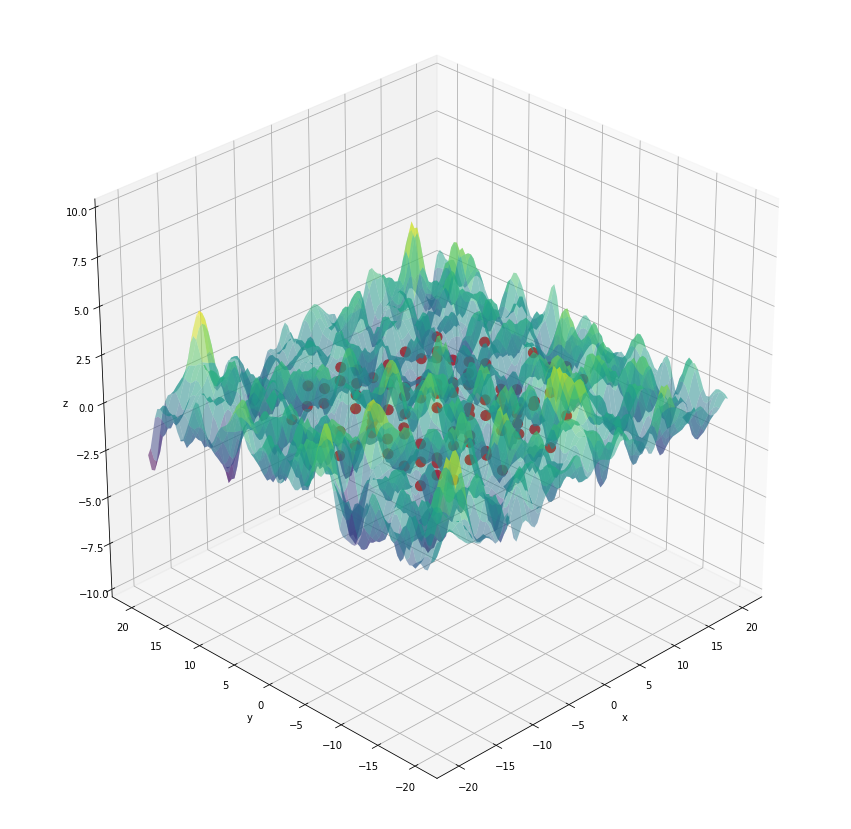

In [17]:
fig = plt.figure()
ax = fig.add_subplot(projection ='3d')
fig.set_size_inches(15,15)
Z = predictions[0][2]


ax.plot_surface(predictions[0][0],predictions[0][1],Z,cmap = 'viridis',alpha =0.5)
ax.scatter(data_x,data_y,label_z,s=100,color = 'red' , label = "data-points",alpha =1 )
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_zlim3d(-10, 10)
ax.view_init(30, -135)


In [ ]:
modelsize = [110]
models = [ create_rff_model_3d(i) for i in modelsize]
predictions2 = train_models_3d(models,data_x,data_y,label_z) 


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


10/10 [==============================] - 0s 3ms/step - loss: 0.0560 - categorical_accuracy: 1.0000


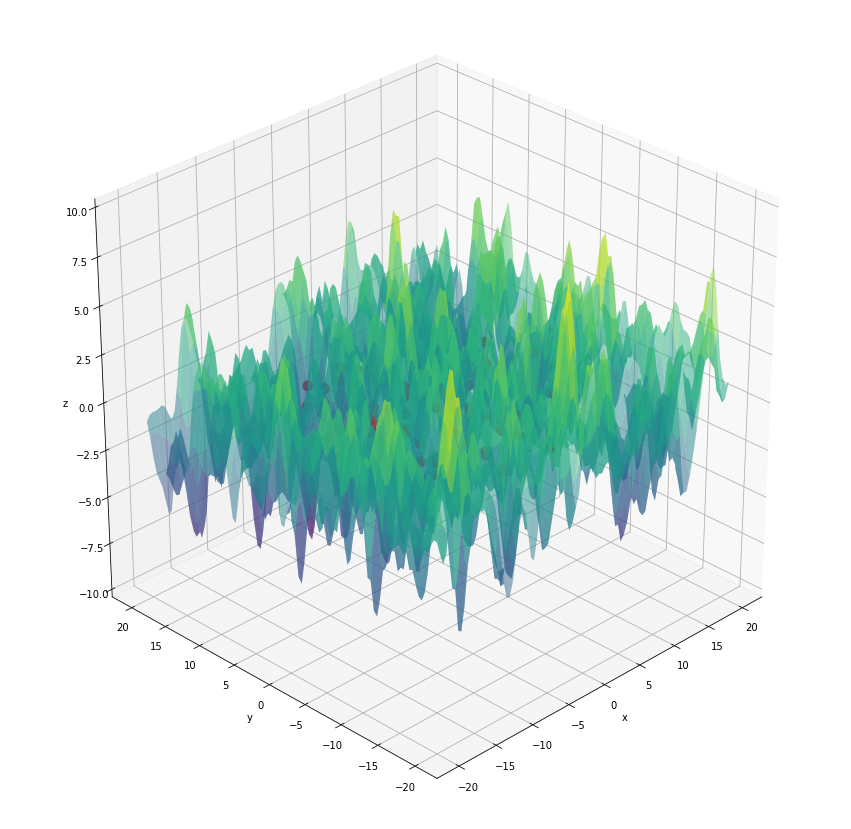

In [16]:
fig = plt.figure()
ax = fig.add_subplot(projection ='3d')
fig.set_size_inches(15,15)
Z = predictions2[0][2]


ax.plot_surface(predictions2[0][0],predictions2[0][1],Z,cmap = 'viridis',alpha = 0.5)
ax.scatter(data_x,data_y,label_z,s=100,color = 'red' , label = "data-points", alpha = 1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_zlim3d(-10, 10)
ax.view_init(30,-135 )

And finaly we take a look at a decision surface 
This time we solve the problem with a normal neuronal network with 1 layer 

In [ ]:
from sklearn.neighbors import KernelDensity

def get_layer_distribution(weights):
  #norm_weights = np.linalg.norm(weights) #if we want to take a look at the full vektor
  norm_weights = weights.flatten().reshape(-1,1)
  axis = np.linspace(np.min(norm_weights), np.max(norm_weights), 100)[:, np.newaxis]
  kde = KernelDensity(kernel='tophat', bandwidth=0.02).fit(norm_weights) #maby gaussian
  dens = kde.score_samples(axis)

  #plt.fill(axis[:,0],np.exp(dens),fc="#AAAAFF", label = "distribution of weightchange")

  return np.array([axis[:,0],dens])

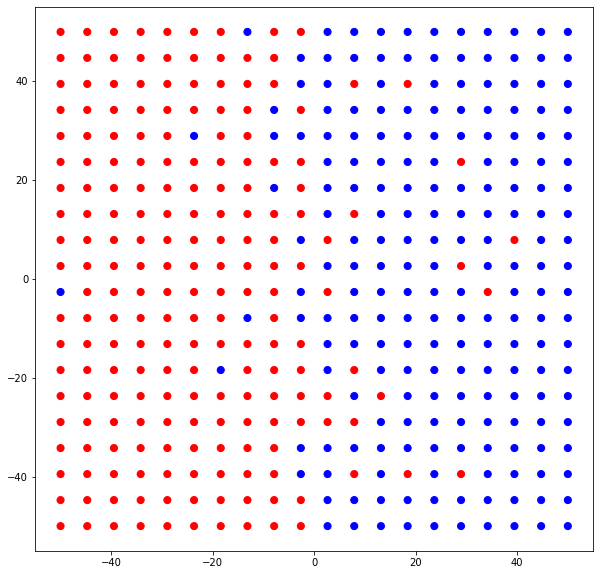

In [ ]:
'''
creating a dataset where the points within a square around the point (0,0)
are labeld 1 and the other points are labeld 2. We will add a little bit of 
nosie to it and see how two different networks with a different amount of parameters performs on it
'''

#creating the data set 
#lets take a 100x100 grid and let the inner 10x10 grid be the square which is labeld as 1 
def noise(x,n):
  r = randrange(0,(int(abs(x))+2))
  if r ==1:
    return int((-np.sign(x) + 1)/2)
  else:  
    return int((np.sign(x) + 1)/2)



def create_grid_data(n):
  x = np.linspace(-50,50,n)
  y = np.linspace(-50,50,n)
  xx,yy = np.meshgrid(x,y)
  Z = np.array([[[a,b] for a in x] for b in y])
  data = np.concatenate(Z)
  label = [noise(a[0],n) for a in data]
  return [xx,yy,np.array(label),data]
  
#Create the data
xx,yy,label,data = create_grid_data(20)

#take a look at the data
colors = ['red' if c == 0 else 'blue' for c in label]

#taking a look at the data
fig, ax = plt.subplots(1)
fig.set_size_inches(10,10)
ax.scatter(data[:,0],data[:,1],color = colors,s=50, label = "data-points")




lets bring some noise into the data

In [ ]:
def create_decission_model(param):
  model = keras.Sequential([
    keras.layers.Flatten(input_shape=(2,)),
    keras.layers.experimental.RandomFourierFeatures(
        output_dim=param,
        kernel_initializer="gaussian"),
    keras.layers.Dense(2, activation='softmax' ,kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.12)),
  ])
  model.compile(optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.05),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
  return model

def train_decision_models(models, data_x,data_y, labels):
  predictions = []
  layer_weights_bevor = []
  layer_weights_after = []

  data = np.array([list(a) for a in zip(np.concatenate(data_x),np.concatenate(data_y))])

  for m in models:
    #getting weightvectors bevor training
    layer_weights = m.layers[2].get_weights()[0][:,0]
    layer_weights_bevor.append(layer_weights)
    
    loss = 100
    epoch_counter =  0
    #training the model until a certain loss is reached or 10000 epochs are reached
    while(loss > 0.0001 and epoch_counter < 10000):
      history = m.fit(data,labels,10)
      epoch_counter = epoch_counter + 10
      train_loss, train_acc = history.history.values()
      loss = train_loss[len(train_loss) -1]
    

    #getting weightvektors after training
    layer_weights_a = m.layers[2].get_weights()[0][:,0]
    layer_weights_after.append(layer_weights_a)


    x = np.linspace(min(data_x[0]),max(data_x[0]),100)
    y = np.linspace(min(data_y[:,0]),max(data_y[:,0]),100)
    xx,yy =np.meshgrid(x,y)
    pred_z=  np.array([[m.predict([[a,b]])[0][0] for a in x] for b in y])
    predictions.append([xx,yy,pred_z])

  return [layer_weights_bevor, layer_weights_after,predictions]

40/40 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 1.0000


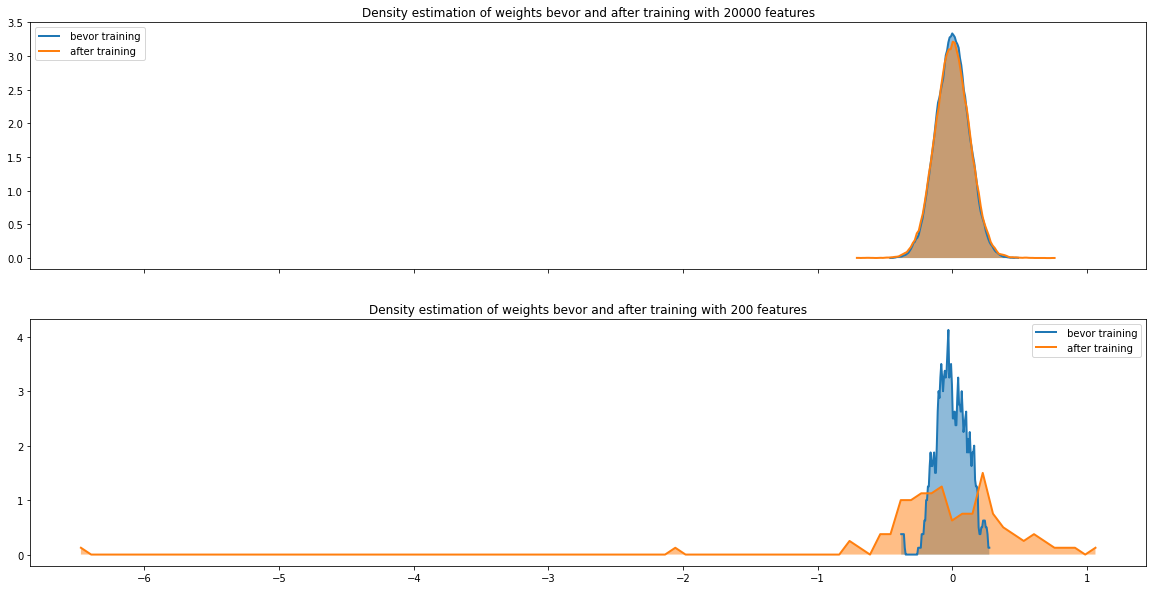

In [ ]:

modelsize = [20000,200]
models = [ create_decission_model(i) for i in modelsize]
lw_b,lw_a,predictions = train_decision_models(models,xx,yy,label)

X1 = predictions[0][0]
Y1 = predictions[0][1]
Z1 = predictions[0][2]

X2 = predictions[1][0]
Y2 = predictions[1][1]
Z2 = predictions[1][2]


#distribution small model
axis_b_low, dens_b_low = get_layer_distribution(lw_b[1])
axis_a_low, dens_a_low = get_layer_distribution(lw_a[1])

#distribution large mdoel
axis_b_high, dens_b_high = get_layer_distribution(lw_b[0])
axis_a_high, dens_a_high = get_layer_distribution(lw_a[0])

#adding 0 to the border of the density function, so the plot looks smoother


#print distributions
fig, ax = plt.subplots(2 ,sharex = True)
fig.set_size_inches(20,10)

ax[0].set_title("Density estimation of weights bevor and after training with " + str(modelsize[0]) + " features")
ax[0].fill_between(axis_b_high,np.exp(dens_b_high), alpha = 0.5)
ax[0].fill_between(axis_a_high,np.exp(dens_a_high), alpha = 0.5)
ax[0].plot(axis_b_high,np.exp(dens_b_high), label = " bevor training", linewidth= 2.0)
ax[0].plot(axis_a_high,np.exp(dens_a_high), label = " after training", linewidth= 2.0)



ax[1].set_title("Density estimation of weights bevor and after training with " + str(modelsize[1]) + " features")
ax[1].fill_between(axis_b_low,np.exp(dens_b_low), alpha = 0.5)
ax[1].fill_between(axis_a_low,np.exp(dens_a_low), alpha = 0.5)
ax[1].plot(axis_b_low,np.exp(dens_b_low), label = " bevor training", linewidth= 2.0)
ax[1].plot(axis_a_low,np.exp(dens_a_low), label = " after training", linewidth= 2.0)

 #legend
ax[0].legend(loc = "upper left")
ax[1].legend(loc = "upper right")






Text(0, 0.5, 'y')

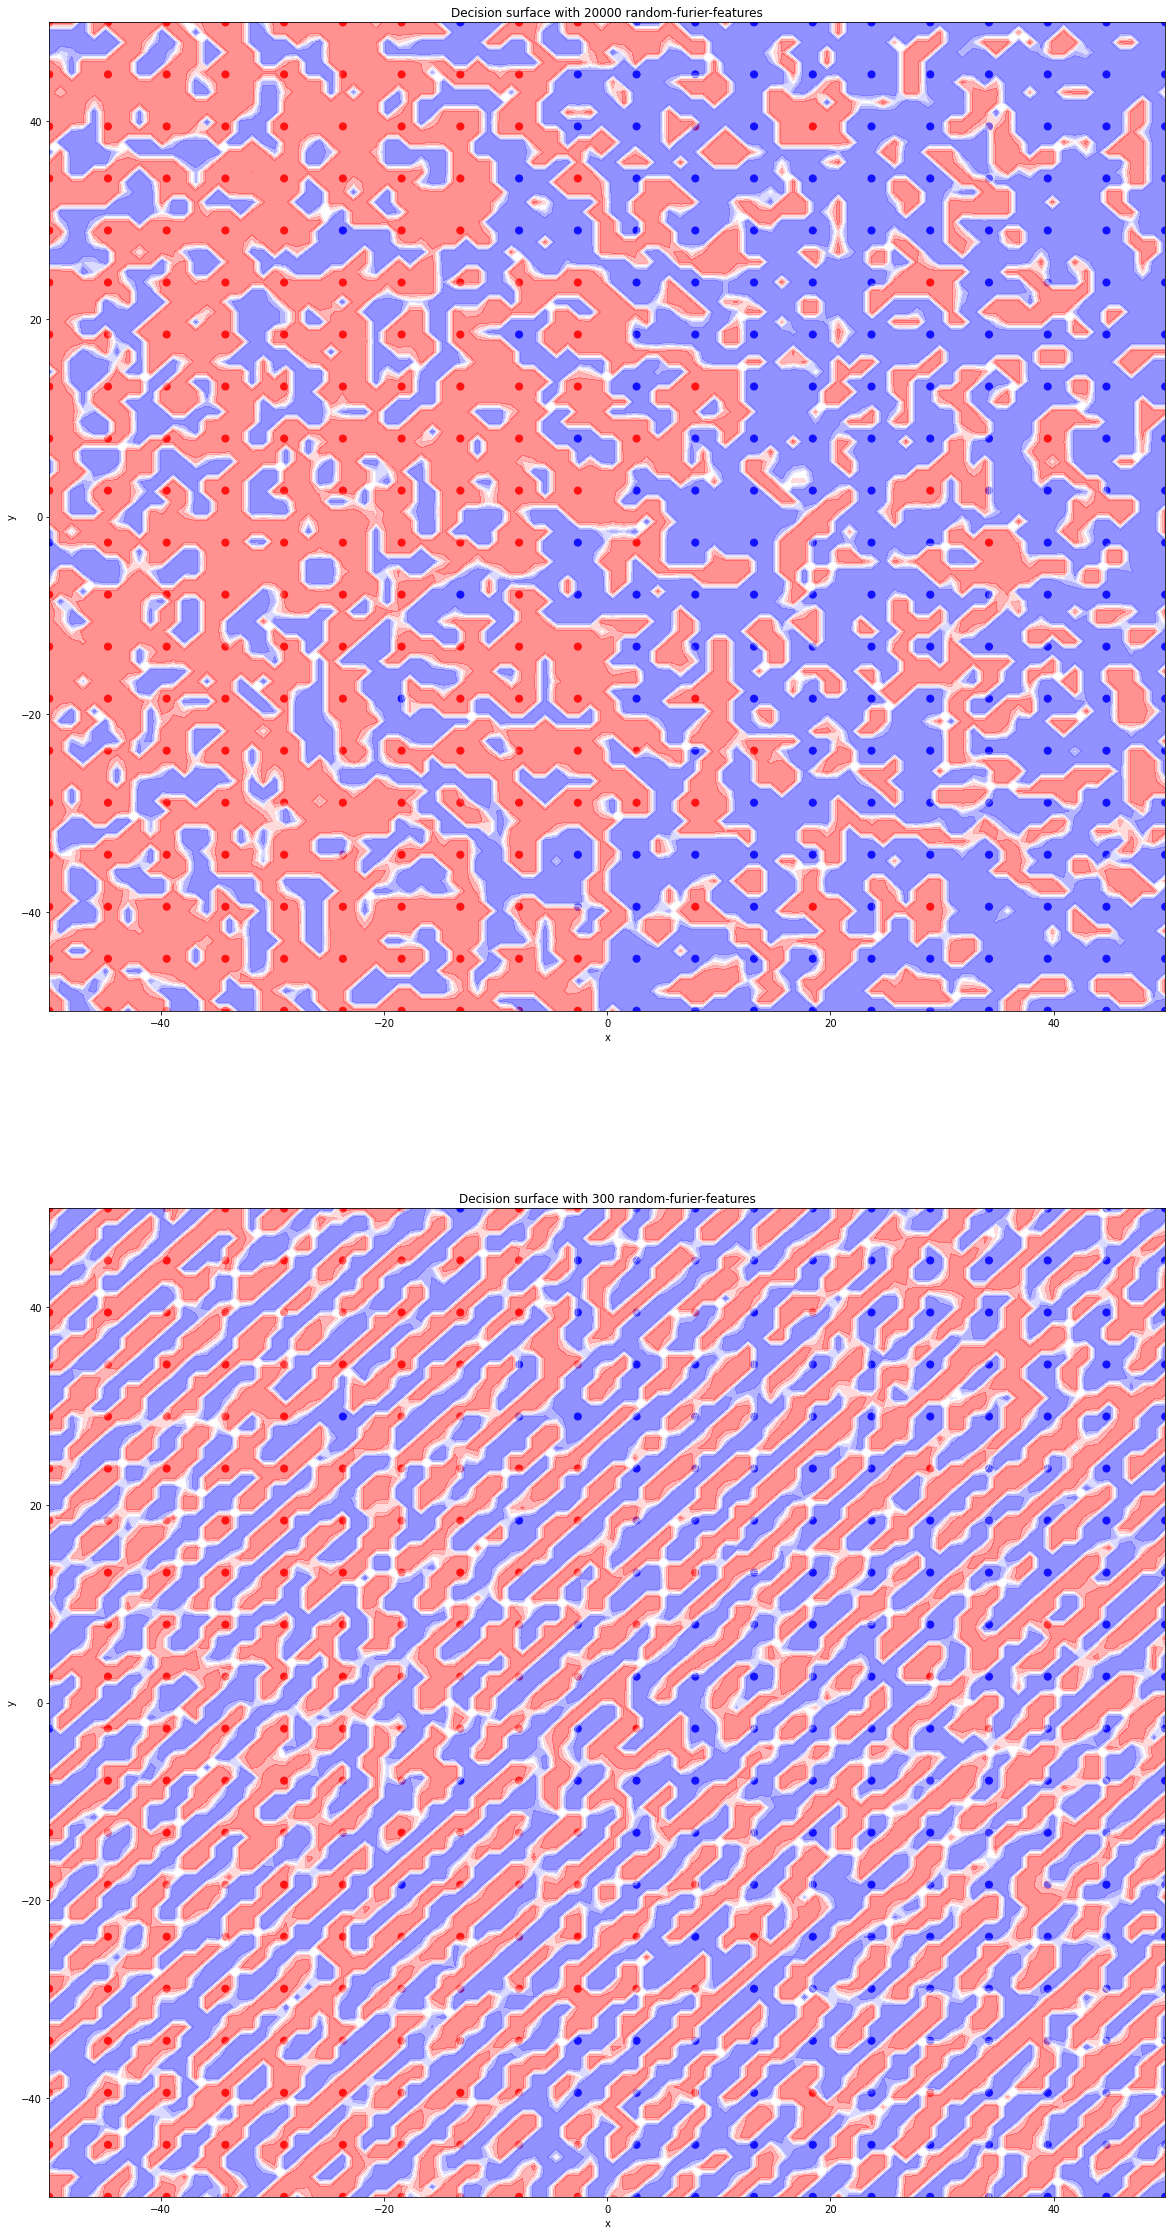

In [ ]:
fig, ax = plt.subplots(2)
#Z1 = Z1.round(decimals=1)
#Z2 = Z2.round(decimals=1)


fig.set_size_inches(20,40)
ax[0].scatter(data[:,0],data[:,1],color = colors,s=50, label = "data-points")
ax[0].contourf(X1,Y1,Z1, alpha = 0.5, cmap ='bwr')
ax[0].set_title("Decision surface with 20000 random-furier-features")
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

ax[1].scatter(data[:,0],data[:,1],color = colors,s=50, label = "data-points")
ax[1].contourf(X2,Y2,Z2, alpha = 0.5, cmap ='bwr')
ax[1].set_title("Decision surface with 300 random-furier-features")
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')